In [1]:
# Python Path non-sense
%load_ext autoreload
%autoreload 2

import sys
import os

# Remove the old path if it exists
#old_path = '/Users/maxw/projects/bayes_gsl'
#if old_path in sys.path:
#    sys.path.remove(old_path)

# remove any paths that contains 'bayes_gsl' in the sys.path
sys.path = [x for x in sys.path if 'bayes_gsl' not in x]
new_path = '/Users/maxw/projects/gsl-bnn/'
if new_path not in sys.path:
    sys.path.append(new_path)
""" 
# Append the new src directory to the system path
new_path = '/Users/maxw/projects/gsl-bnn/'
if new_path not in sys.path:
    sys.path.append(new_path)

# Confirm that the src directory is in the system path
print("Current sys.path:")
for path in sys.path:
    print(path)

"""

' \n# Append the new src directory to the system path\nnew_path = \'/Users/maxw/projects/gsl-bnn/\'\nif new_path not in sys.path:\n    sys.path.append(new_path)\n\n# Confirm that the src directory is in the system path\nprint("Current sys.path:")\nfor path in sys.path:\n    print(path)\n\n'

In [2]:
import os
import pickle
import arviz
import matplotlib.pyplot as plt
import numpyro.infer
import seaborn as sns
from sklearn.calibration import calibration_curve
import numpy as np
from scipy.linalg import block_diag
import multiprocessing
import pandas as pd
import random
import time
import collections

### THIS MUST OCCUR BEFORE JAX IS IMPORTED ###
# for parallelization for multiple chains. Must be done before jax import:
# Blackjax tutorial: https://blackjax-devs.github.io/blackjax/examples/howto_sample_multiple_chains.html
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)
import jax 
import jax.numpy as jnp
from jax import random as jax_random
from jax.random import PRNGKey
print("Number of CPU cores:", jax.local_device_count()) # often will not allow multi-threading in Jupyter notebooks

import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import init_to_value
plt.style.use("bmh")
#from IPython.display import set_matplotlib_formats
import matplotlib_inline
if "NUMPYRO_SPHINXBUILS" in os.environ:
    #set_matplotlib_formats("svg")
    matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide

#sys.path.append('/content/bayes_gsl') # for colab

from src import TMLR_TEXTWIDTH, TMLR_PLOT_DEPTH, FIGURES_PATH, FINANCIAL_DATA_PATH, NUM_BINS

from src.models import dpg_bnn
#from src.data import load_data
from src.metrics import compute_metrics

from src.config import num_samples_to_generate, w_init_scale, lam_init_scale, altered_prior
from experiments.financial.config import dpg_hyperparameters, experiment_settings
from src.utils import edge_density, adj2vec, vec2adj, degrees_from_upper_tri
from src.models import unroll_dpg, dpg_bnn

Number of CPU cores: 8


## Load Stock Data
Data from "Graphical Models in Heavy-Tailed Markets" by José Vinícius de M. Cardoso, Jiaxi Ying, Daniel P. Palomar
https://github.com/convexfi/fingraph/

In [ ]:
random.seed(123)
SP500 = pd.read_csv(f"{FINANCIAL_DATA_PATH}SP500-sectors.csv")
stock_prices = pd.read_csv(f"{FINANCIAL_DATA_PATH}stock-data-2014-2018.csv", parse_dates=True)

print(len(stock_prices.columns), stock_prices.columns)

In [ ]:
SP500

In [ ]:
# only use stocks that are in the stock_prices
stock_to_sector_map = {}
for stock in stock_prices.columns:
    stock_to_sector_map[stock] = SP500[SP500['Symbol'] == stock]['GICS.Sector'].values[0]

In [ ]:
sectors = {'Communication Services', 'Utilities', 'Real Estate'}

## Split Stocks into Train/Test

In [ ]:
train_stock_prices = pd.DataFrame(columns=stock_prices.columns)
test_stock_prices = pd.DataFrame(columns=stock_prices.columns)

# Perform stratified sampling
for sector in set(stock_to_sector_map.values()):
    sector_stocks = [ticker for ticker, sec in stock_to_sector_map.items() if sec == sector]
    # Randomly split the sector's stocks into two halves
    np.random.shuffle(sector_stocks)
    half = len(sector_stocks) // 2
    
    train_stocks = sector_stocks[:half]
    test_stocks = sector_stocks[half:]
    
    train_stock_prices[train_stocks] = stock_prices[train_stocks]
    test_stock_prices[test_stocks] = stock_prices[test_stocks]
    
    print(f'Sector {sector}')
    print(f'\tTrain set: {sorted(train_stocks)}')
    print(f'\tTest set: {sorted(test_stocks)}')
print('\n\n')

# Drop columns that didn't make it to either train or test sets
train_stock_prices.dropna(axis=1, how='all', inplace=True)
test_stock_prices.dropna(axis=1, how='all', inplace=True)

print("Train set columns:", train_stock_prices.columns)
print("Test set columns:", test_stock_prices.columns)
n_train, n_test = len(train_stock_prices.columns), len(test_stock_prices.columns)
num_edges_train, num_edges_test = n_train * (n_train - 1) // 2, n_test * (n_test - 1) // 2

In [ ]:
# reorder columns so sectors are contiguos. Makes things easy/pretty plotting.
train_stock_prices = train_stock_prices.reindex(sorted(train_stock_prices.columns, key=lambda x: stock_to_sector_map[x]), axis=1)
test_stock_prices = test_stock_prices.reindex(sorted(test_stock_prices.columns, key=lambda x: stock_to_sector_map[x]), axis=1)

## Compute Dissimilarity Matrix: 1 - Correlation of Log Returns

In [ ]:
train_log_returns = np.log(train_stock_prices / train_stock_prices.shift(1))
train_log_returns = train_log_returns.dropna()

test_log_returns = np.log(test_stock_prices / test_stock_prices.shift(1))
test_log_returns = test_log_returns.dropna()

In [ ]:
# make plot with two subplots showing the correlation matrices
# train
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Train set')
plt.imshow(train_log_returns.corr())
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title('Test set')
plt.imshow(test_log_returns.corr())
plt.colorbar()

In [ ]:
print(f'min {train_log_returns.corr().to_numpy().min()}') # there are some negative correlations in both. Take abs value.
print(f'min {test_log_returns.corr().to_numpy().min()}')

# plot histograms of the correlations
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Train set')
axs[0].hist(train_log_returns.corr().to_numpy().flatten(), bins=100);
axs[1].set_title('Test set')
axs[1].hist(test_log_returns.corr().to_numpy().flatten(), bins=100);


In [ ]:
# correlation: 1 - correlation to get something proportional to distance
log_return_observations_train = 1 - np.abs(train_log_returns.corr().to_numpy())
log_return_observations_test = 1 - np.abs(test_log_returns.corr().to_numpy())

log_return_observations_train_mat = jnp.reshape(log_return_observations_train, (1, n_train, n_train))
log_return_observations_test_mat = jnp.reshape(log_return_observations_test, (1, n_test, n_test))

### Visualize Dissimilarity Matrix

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

cax = ax.matshow(log_return_observations_train, cmap='coolwarm')
plt.title('Dissimilarity Matrix: 1 - |correlation|', y=1.2)
fig.colorbar(cax)

ax.set_xticks(np.arange(len(train_stock_prices.columns)))
ax.set_yticks(np.arange(len(train_stock_prices.columns)))

ax.set_xticklabels(train_stock_prices.columns, rotation=90)
ax.set_yticklabels(train_stock_prices.columns)

# Color the tick labels based on the sector
colors = {'Communication Services': 'red', 'Utilities': 'blue', 'Real Estate': 'green'}
for tick_label in ax.get_xticklabels():
    ticker = tick_label.get_text()
    sector = stock_to_sector_map.get(ticker, 'Unknown')
    tick_label.set_color(colors.get(sector, 'black'))

for tick_label in ax.get_yticklabels():
    ticker = tick_label.get_text()
    sector = stock_to_sector_map.get(ticker, 'Unknown')
    tick_label.set_color(colors.get(sector, 'black'))

plt.tight_layout()
plt.show()

## Construct the Label: The Binary Block Diagonal Sector Graphs

In [ ]:
# find number of stocks in each sector for train set
sector_sizes_train = {}
for sector in set(stock_to_sector_map.values()):
    for ticker in train_stock_prices.columns:
        if stock_to_sector_map[ticker] == sector:
            sector_sizes_train[sector] = sector_sizes_train.get(sector, 0) + 1

# find number of stocks in each sector for test set
sector_sizes_test = {}
for sector in set(stock_to_sector_map.values()):
    for ticker in test_stock_prices.columns:
        if stock_to_sector_map[ticker] == sector:
            sector_sizes_test[sector] = sector_sizes_test.get(sector, 0) + 1

print(f"Number of stocks in each sector for train set: \n\ttrain set: {sector_sizes_train}, \n\ttest set: {sector_sizes_test}")
num_train_comms, num_train_real_estate, num_train_utilities = sector_sizes_train['Communication Services'], sector_sizes_train['Real Estate'], sector_sizes_train['Utilities']
num_test_comms, num_test_real_estate, num_test_utilities = sector_sizes_test['Communication Services'], sector_sizes_test['Real Estate'], sector_sizes_test['Utilities']

sector_graph_label_train = block_diag(np.ones((num_train_comms, num_train_comms)), np.ones((num_train_real_estate, num_train_real_estate)), np.ones((num_train_utilities, num_train_utilities)))
sector_graph_label_test = block_diag(np.ones((num_test_comms, num_test_comms)), np.ones((num_test_real_estate, num_test_real_estate)), np.ones((num_test_utilities, num_test_utilities)))

sector_graph_label_train_mat = jnp.reshape(sector_graph_label_train, (1, n_train, n_train))
sector_graph_label_test_mat = jnp.reshape(sector_graph_label_test, (1, n_test, n_test))


# 2 subplots showing labels for train and test sets
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed
plt.subplot(1, 2, 1)
plt.title('Train set')
plt.imshow(sector_graph_label_train, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Test set')
plt.imshow(sector_graph_label_test,  cmap='gray')


## Prior Modeling with Indeped. Interpretable Theta. Use Train Data.

In [ ]:
def calculate_scores(y_true, y_pred, eps=1e-3):
    # Ensure inputs are numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred > eps)
    assert y_true.shape == y_pred.shape, f'compute_scores recieved incompatible shapes'

    # true positive
    TP = np.sum((y_pred == 1) & (y_true == 1), axis=1)
    # true negatives
    TN = np.sum((y_pred == 0) & (y_true == 0), axis=1)
    # false positives
    FP = np.sum((y_pred == 1) & (y_true == 0), axis=1)
    # false negatives
    FN = np.sum((y_pred == 0) & (y_true == 1), axis=1)

    # false positive rate
    FPR = FP / (FP + TN)
    # false negative rate
    FNR = FN / (FN + TP)
    # precision
    precision = TP / (TP + FP)
    # recall
    recall = TP / (TP + FN)
    # F1 score
    F1 = 2 * ((precision * recall) / (precision + recall))
    # Error Rate
    error = (FP + FN) / (TP + FP + TN + FN)

    return FPR, FNR, F1, error

# define the search space for \theta: sample uniformly on a log scale from 100 to 4000
thetas = np.logspace(-.5, 1, 10)
depth = 2*10**4 # to ensure convergence
threshold = 1e-3
performance = collections.defaultdict(dict)
solution = collections.defaultdict(dict)

num_train_samples_ = 1
jnp.reshape(log_return_observations_train, (1, n_train, n_train))
log_return_observations_train = jnp.reshape(log_return_observations_train, (1, n_train, n_train))
print(f'Label shape {sector_graph_label_train.shape}, log return shape {log_return_observations_train.shape}, num train samples {num_train_samples_}')

a, e, = adj2vec(sector_graph_label_train_mat),  adj2vec(log_return_observations_train)
w_init, lam_init = w_init_scale * jnp.ones((num_train_samples_, num_edges_train)), lam_init_scale * jnp.ones((num_train_samples_, n_train))
w, lam = None, None
S = jnp.array(degrees_from_upper_tri(n_train))

for i, theta in enumerate(thetas):
    theta_start_time = time.time()
    print(f'\t{i+1}/{len(thetas)}: theta = {theta:.3f}')
    w, lam = unroll_dpg(
        x=e,
        w_init=w_init if w is None else w, # for convergence speed up: last convergent variables will be similar to the new
        lam_init=lam_init if lam is None else lam,
        theta=theta,
        num_steps=depth,
        S=S)
    FPR, FNR, F1, error = calculate_scores(a, w, eps=threshold)
    ed = edge_density(w>threshold)
    performance[theta] = {'FPR': FPR, 'FNR': FNR, 'F1': F1, 'error': error, 'edge_density': ed}
    solution[theta] = {'w': w, 'lam': lam}
    print(f'\t\ttime {time.time() - theta_start_time:.3f} | edge density {ed.mean()*100:.2f} %, error {error.mean()*100:.1f} %, F1 {F1.mean()*100:.3f} %, FPR {FPR.mean()*100:.3f} %, FNR {FNR.mean()*100:.3f} %')

In [ ]:
""" Plot edge density, error, F1 vs theta """
# plot edge density, error, F1 vs theta
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(thetas, [performance[theta]['edge_density'].mean() for theta in thetas])
axs[0].set_title('Edge Density vs Theta')
axs[0].set_xlabel('Theta')
axs[0].set_ylabel('Edge Density')
axs[1].plot(thetas, [performance[theta]['error'].mean() for theta in thetas])
axs[1].set_title('Error vs Theta')
axs[1].set_xlabel('Theta')
axs[1].set_ylabel('Error')
#axs[2].plot(thetas, [performance[theta]['F1'].mean() for theta in the thetas])
axs[2].plot(thetas, [performance[theta]['F1'].mean() for theta in thetas])
axs[2].set_title('F1 vs Theta')
axs[2].set_xlabel('Theta')
axs[2].set_ylabel('F1')

# set log scale for theta
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

plt.show()

In [ ]:
""" Plot the edge weight distribution for each theta. Each theta should have a box and whisker plot. """
# edge weights are stores in solution[theta]['w']

import matplotlib.pyplot as plt
import numpy as np

# extract the edge weights for each theta
edge_weights = {theta: solution[theta]['w'] for theta in thetas}

# create box and whisker plot with min, max, median, and quartiles for edge weights at each theta. This should all be done on the same plot.
fig, ax = plt.subplots(figsize=(15, 5))
ax.boxplot([edge_weights[theta].flatten()[edge_weights[theta].flatten() > 1e-6] for theta in thetas], labels=[f'{theta:.3f}' for theta in thetas])
# set xticklabels to be the rounded theta values. Rotate the labels 45 degrees.
# % of non-zero edge weights for each theta
percent_non_zero = [100*(edge_weights[theta].flatten() > 1e-6).mean() for theta in thetas]
ax.set_xticklabels([f'{theta:.1f}/({percent_non_zero[i]:.1f}%)' for i, theta in enumerate(thetas)], rotation=45)
ax.set_title('Non-zero (>1e-6) Edge Weight Distribution vs Theta')
ax.set_xlabel('Theta')
ax.set_ylabel('Edge Weight')
ax.set_yscale('log')
plt.show()

In [ ]:
for theta in thetas:
    s = solution[theta]['w']
    s = vec2adj(s, n=n_train)[0]
    plt.imshow(s, cmap='Greys')
    plt.title(f'Theta = {theta:.3f}')
    plt.colorbar()
    plt.show()

## Run Bayesian Parameter Inference

In [ ]:
### configure model
num_train_samples_ = 1
#w_init, lam_init = 0.5 * jnp.ones((num_train_samples_, num_edges_train)), 17 * jnp.ones((num_train_samples_, n_train))

model_args = \
    {'x': adj2vec(log_return_observations_train), 'y': adj2vec(sector_graph_label_train_mat),
     'depth': dpg_hyperparameters['depth'], 
     'w_init': w_init_scale * jnp.ones((num_train_samples_, num_edges_train)), 'lam_init': lam_init_scale * jnp.ones((num_train_samples_, n_train)),
     'S': S,
     'prior_settings': dpg_hyperparameters['prior']} # same 'altered prior' used

test_model_args = \
    {'x': adj2vec(log_return_observations_test_mat), 'y': adj2vec(sector_graph_label_test_mat),
    'depth': dpg_hyperparameters['depth'], 
    'w_init': w_init_scale * jnp.ones((num_train_samples_, num_edges_test)), 'lam_init': lam_init_scale * jnp.ones((num_train_samples_, n_test)),
    'S': jnp.array(degrees_from_upper_tri(n_test)),
    'prior_settings': dpg_hyperparameters['prior']}

In [ ]:
#w_test, lam_test = jnp.squeeze(w_init), jnp.squeeze(lam_init)
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = jax.random.PRNGKey(0)
rng_key, rng_key_ = jax.random.split(rng_key)

model = dpg_bnn.model
kernel = NUTS(model, forward_mode_differentiation=True)
mcmc = MCMC(kernel,
            num_warmup=experiment_settings['num_warmup_samples'], num_samples=experiment_settings['num_posterior_samples'],
            progress_bar=True,
            num_chains=experiment_settings['num_chains'], chain_method='parallel')
start_time = time.time()
mcmc.run(rng_key_, **model_args)
end_time = time.time()
print(f"Time taken for inference using {experiment_settings['num_chains']} with {experiment_settings['num_warmup_samples']} warmup samples and {experiment_settings['num_posterior_samples']} samples: {end_time - start_time}")
mcmc.print_summary()
print(f"^^********** Finished  **********^^\n\n")
samples = mcmc.get_samples()

In [ ]:
# visualize the posterior sample distributions
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(samples['theta'].reshape(-1,), bins=50)
axs[0].set_title('Theta')
axs[1].hist(samples['delta'].reshape(-1,), bins=50)
axs[1].set_title('Delta')
axs[2].hist(samples['b'].reshape(-1,), bins=50)
axs[2].set_title('b')
plt.show()


## Save/Load Posterior Samples and Data

In [3]:
# FIRST TWO CELLS MUST BE RUN BEFORE THIS
results_path = experiment_settings['results_path'] + 'samples_and_data.pkl'

In [ ]:
# save
with open(results_path, 'wb') as f:
    pickle.dump({'samples': samples, 
                 'log_return_observations_train': log_return_observations_train, 
                 'log_return_observations_test': log_return_observations_test, 
                 'sector_graph_label_train': sector_graph_label_train, 
                 'sector_graph_label_test': sector_graph_label_test,
                 'model_args': model_args,
                 'test_model_args': test_model_args}, f)

In [18]:
# load these results
with open(results_path, 'rb') as f:
    results = pickle.load(f)
    samples = results['samples']
    log_return_observations_train = results['log_return_observations_train']
    log_return_observations_test = results['log_return_observations_test']
    sector_graph_label_train = results['sector_graph_label_train']
    sector_graph_label_test = results['sector_graph_label_test']
    model_args = results['model_args']
    test_model_args = results['test_model_args']

n_train, n_test = log_return_observations_train.shape[1], log_return_observations_test.shape[1]
sector_graph_label_train_mat = jnp.reshape(sector_graph_label_train, (1, n_train, n_train))
sector_graph_label_test_mat = jnp.reshape(sector_graph_label_test, (1, n_test, n_test))
log_return_observations_train_mat = jnp.reshape(log_return_observations_train, (1, n_train, n_train))
log_return_observations_test_mat = jnp.reshape(log_return_observations_test, (1, n_test, n_test))

In [19]:
edge_logits = dpg_bnn.forward_pass_vmap()(samples['theta'], samples['delta'], samples['b'],
                                          model_args['x'], 
                                          model_args['w_init'], 
                                          model_args['lam_init'], 
                                          model_args['depth'], 
                                          model_args['S']
                                          )
edge_logits = jnp.squeeze(edge_logits)

test_edge_logits = dpg_bnn.forward_pass_vmap()(samples['theta'], samples['delta'], samples['b'],
                                               test_model_args['x'], 
                                               test_model_args['w_init'], 
                                               test_model_args['lam_init'],
                                               test_model_args['depth'], 
                                               test_model_args['S']
                                               )
test_edge_logits = jnp.squeeze(test_edge_logits)

print(f"Edge logits shape: {edge_logits.shape}, test edge logits shape: {test_edge_logits.shape}")

Edge logits shape: (4000, 780), test edge logits shape: (4000, 861)


## Evaluation and Plotting

In [14]:
def plot_results(label, input, edge_logits, n, sampling_posterior_predictive=True):
    label_adj = label
    # add leading dimension to label
    label = adj2vec(jnp.expand_dims(label, 0))
    edge_probs = jax.nn.sigmoid(edge_logits)
    if sampling_posterior_predictive:
        # draw samples from the posterior preditive
        posterior_predictive_edge_samples = jax.random.bernoulli(jax.random.PRNGKey(0), edge_probs) + 0.0
        mean_edge_marginal_post_pred_estimate = np.array(posterior_predictive_edge_samples.mean(axis=0))
        std_edge_marginal_post_pred_estimate = np.array(posterior_predictive_edge_samples.std(axis=0))
        # add trailing dimension to mean and std
        mean_edge_marginal_post_pred_estimate = np.expand_dims(mean_edge_marginal_post_pred_estimate, 0)
        std_edge_marginal_post_pred_estimate = np.expand_dims(std_edge_marginal_post_pred_estimate, 0)
        error_l1 = np.abs(mean_edge_marginal_post_pred_estimate - label)
        pos_error_l1 = error_l1[label == 1]
        neg_error_l1 = error_l1[label == 0]
        pos_uncertainty = std_edge_marginal_post_pred_estimate[label == 1]
        neg_uncertainty = std_edge_marginal_post_pred_estimate[label == 0]

        mean_plot = mean_edge_marginal_post_pred_estimate
        std_plot = std_edge_marginal_post_pred_estimate
        mean_adj_plot = vec2adj(mean_edge_marginal_post_pred_estimate, n=n).squeeze()
        std_adj_plot = vec2adj(std_edge_marginal_post_pred_estimate, n=n).squeeze()

    else:
        mean_edge_probs = edge_probs.mean(axis=0, keepdims=True) ### UPDATE THIS WITH SAMPLING!!!!
        std_edge_probs = edge_probs.std(axis=0, keepdims=True)
        mean_edge_probs_adj = vec2adj(mean_edge_probs, n=n).squeeze()
        std_edge_probs_adj = vec2adj(std_edge_probs, n=n).squeeze()
        error_l1 = np.abs(mean_edge_probs - label)

        #error_l1 = np.log10(error_l1 + 1e-8)
        #std_edge_probs = np.log10(std_edge_probs + 1e-8)

        # find the error_l1 for positive and negative edges
        pos_error_l1 = error_l1[label == 1]
        neg_error_l1 = error_l1[label == 0]

        # find the uncertainty for positive and negative edges
        pos_uncertainty = std_edge_probs[label == 1]
        neg_uncertainty = std_edge_probs[label == 0]

        mean_plot = mean_edge_probs
        std_plot = std_edge_probs
        mean_adj_plot = mean_edge_probs_adj
        std_adj_plot = std_edge_probs_adj

    # plot label, mean, and std
    num_subplots = 3
    fig, axs = plt.subplots(1, num_subplots, figsize=(15, 5))
    
    # Turn off tick labels and adjust spacing
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    axs[0].imshow(label_adj, cmap='gray')
    axs[1].imshow(mean_adj_plot, cmap='gray')
    axs[2].imshow(std_adj_plot, cmap='gray')
    if num_subplots == 4:
        axs[num_subplots-1].imshow(input, cmap='gray')
    
    # Set titles as y-labels beneath the plots and increase the fontsize
    labels = ['Label', 'pred. mean', 'pred. stdv', 'Log Returns 1-Correlations'][:num_subplots]
    for i, ax in enumerate(axs):
        ax.set_xlabel(labels[i], fontsize=18)
        ax.xaxis.set_label_position('top') # Position the label at the top
    
    # Reduce space between plots
    plt.tight_layout()
    plt.show()

    plt.figure()
    # plot the error vs uncertainty for positive and negative edges
    plt.scatter(pos_uncertainty, pos_error_l1, label='uncertainty (positive edges) vs error (l1)')
    plt.scatter(neg_uncertainty, neg_error_l1, label='uncertainty (negative edges) vs error (l1)')
    #plt.scatter(error_l1, std_edge_probs, label='error (l1) vs uncertainty (all edges)')
    
    # fit a line to each and plot
    pos_fit_line = np.polyfit(pos_uncertainty, pos_error_l1, 1)
    neg_fit_line = np.polyfit(neg_uncertainty, neg_error_l1, 1)
    plt.plot(pos_uncertainty, pos_fit_line[0] * pos_uncertainty + pos_fit_line[1], label='fit line (pos)')
    plt.plot(neg_uncertainty, neg_fit_line[0] * neg_uncertainty + neg_fit_line[1], label='fit line (neg)')
    
    # fit a beta distribution to the distribution of error_l1_pos, error_l1_neg
    #beta_params_pos = beta.fit(pos_error_l1.reshape(-1))
    #beta_params_neg = beta.fit(neg_error_l1.reshape(-1))
    # plot the beta distribution
    #x = np.linspace(0, 1, 100)
    #plt.plot(x, beta.pdf(x, *beta_params_pos)/100, label='beta distribution (pos)')
    #plt.plot(x, beta.pdf(x, *beta_params_neg)/100, label='beta distribution (neg)')

    plt.legend()
    plt.xlabel('Uncertainty')
    plt.ylabel('Error')
    plt.show()


        # measure the correlation between error and uncertainty
    print(f"Correlation between error and uncertainty (l1): {np.corrcoef(error_l1.reshape(-1), std_plot.reshape(-1))[0, 1]}")
    print(f"Correlation between error and uncertainty (l1) (pos): {np.corrcoef(pos_error_l1.reshape(-1), pos_uncertainty.reshape(-1))[0, 1]}")
    print(f"Correlation between error and uncertainty (l1) (neg): {np.corrcoef(neg_error_l1.reshape(-1), neg_uncertainty.reshape(-1))[0, 1]}")

### On Train Sample

In [22]:
#plot_results(sector_graph_label_train_mat[0], log_return_observations_train_mat[0], edge_logits, n_train, False)

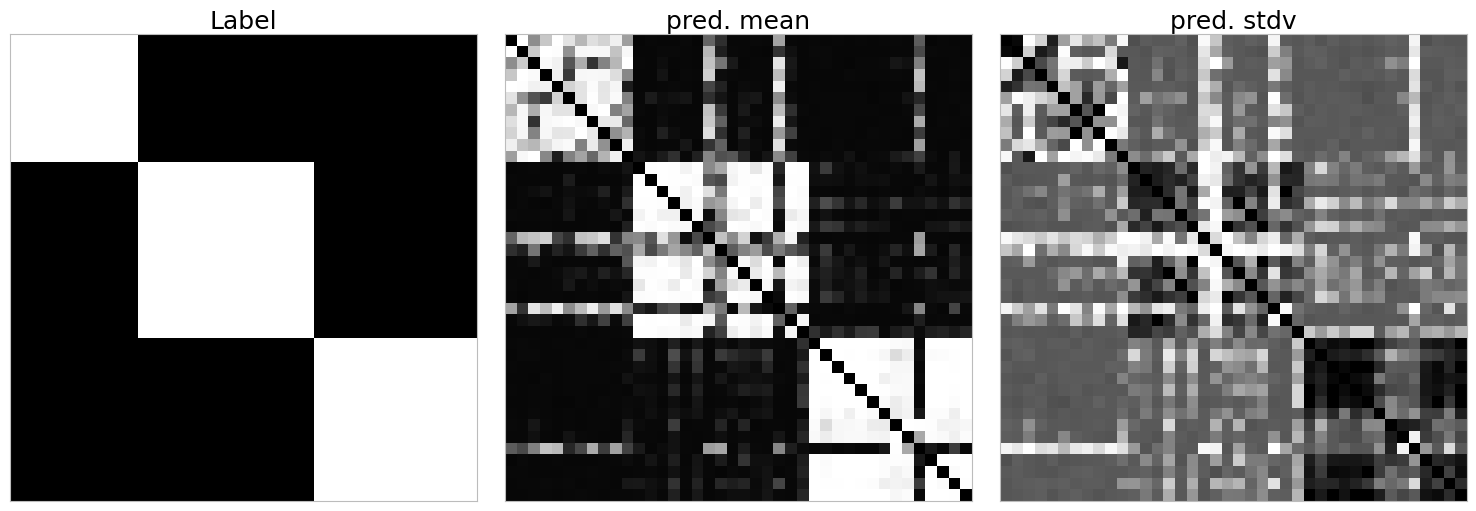

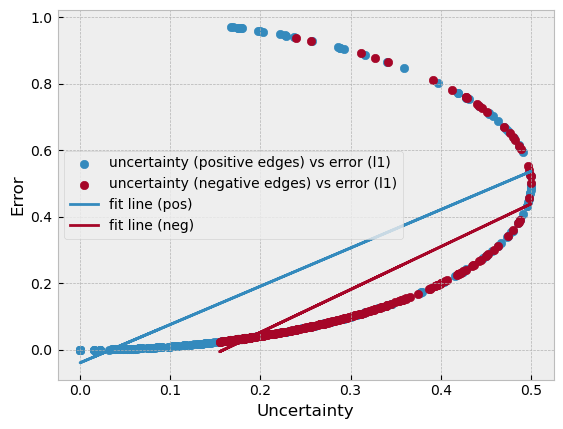

Correlation between error and uncertainty (l1): 0.6020346245194708
Correlation between error and uncertainty (l1) (pos): 0.5893429069038675
Correlation between error and uncertainty (l1) (neg): 0.7436283250028972


In [21]:
plot_results(sector_graph_label_train_mat[0], log_return_observations_train_mat[0], edge_logits, n_train, True)

### On Test Sample

In [23]:
print(f"shape: label {sector_graph_label_test_mat.shape}, input {log_return_observations_test_mat.shape}, edge_logits {test_edge_logits.shape}")
#plot_results(sector_graph_label_test_mat[0], log_return_observations_test_mat[0], test_edge_logits, n_test, False) # average/stdv of logits

shape: label (1, 42, 42), input (1, 42, 42), edge_logits (4000, 861)


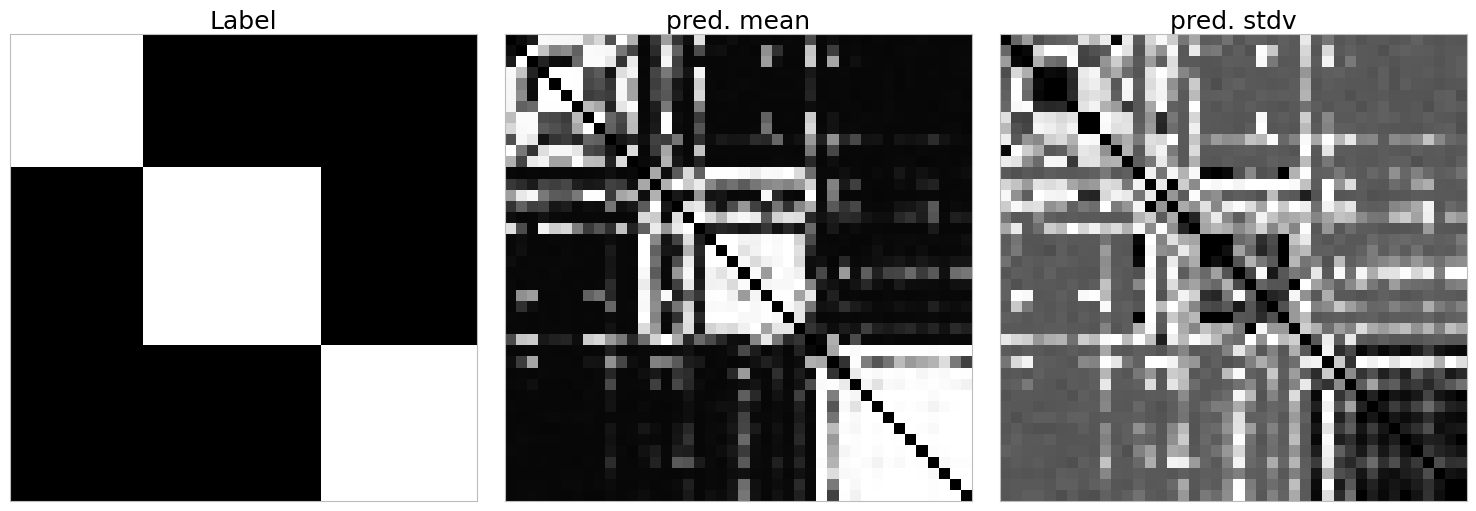

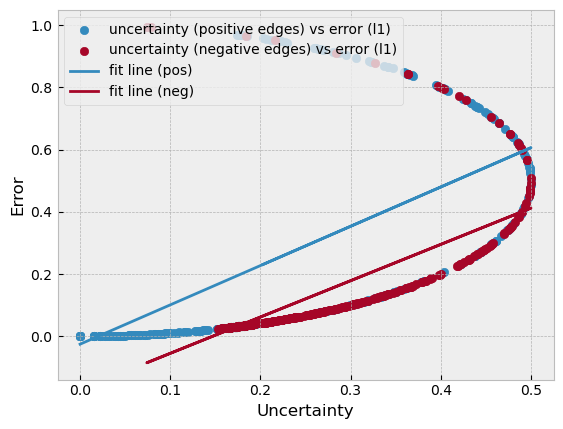

Correlation between error and uncertainty (l1): 0.622071419156854
Correlation between error and uncertainty (l1) (pos): 0.6346532508085473
Correlation between error and uncertainty (l1) (neg): 0.6816814454806326


In [24]:
plot_results(sector_graph_label_test_mat[0], log_return_observations_test_mat[0], test_edge_logits, n_test, sampling_posterior_predictive=True) # sampling of posterior predictive

### Paper Figure: One w/o colorbar, one with

Label (1, 42, 42), Input (1, 42, 42), Edge logits (4000, 1, 861)


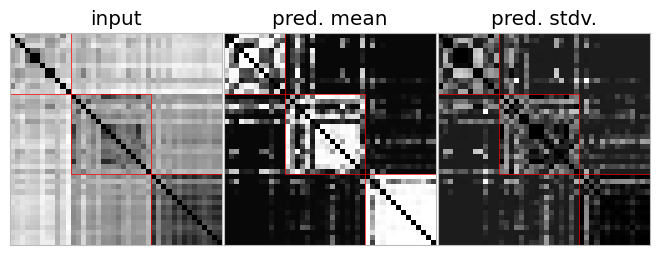

In [27]:
# NO COLOR BAR

def final_figure(label, input, edge_logits, n, label_block_sizes):
    print(f"Label {label.shape}, Input {input.shape}, Edge logits {edge_logits.shape}")
    edge_probs = jax.nn.sigmoid(edge_logits)
    
    mean_edge_probs = edge_probs.mean(axis=0, keepdims=False)
    std_edge_probs = edge_probs.std(axis=0, keepdims=False)
    mean_edge_probs_adj = vec2adj(mean_edge_probs, n=n).squeeze()
    std_edge_probs_adj = vec2adj(std_edge_probs, n=n).squeeze()

    # plot label, mean, and std
    fig, axs = plt.subplots(1, 3) #3)

    axs[0].imshow(input[0], cmap='gray')
    axs[0].set_title('input')# #'log return 1-corr')

    # left most plot is the mean
    axs[1].imshow(mean_edge_probs_adj, cmap='gray')
    axs[1].set_title('pred. mean')

    # middle plot is the stdv
    axs[2].imshow(std_edge_probs_adj, cmap='gray')
    axs[2].set_title('pred. stdv.')

    # Block sizes for the sector_graph_label_test_mat, used for drawing the block diagonals
    block_indices = np.cumsum([0] + label_block_sizes)
    # Drawing a thin line around the block diagonals for both subplots
    for ax, data_adj in zip(axs.flat, [input[0], mean_edge_probs_adj, std_edge_probs_adj]):
        for start, end in zip(block_indices[:-1], block_indices[1:]):
            # Draw a rectangle around the block diagonal
            rect = plt.Rectangle((start-0.5, start-0.5), end-start, end-start, 
                                 fill=False, color='red', linestyle='-', linewidth=0.5)
            ax.add_patch(rect)

    # remove the x and y ticks
    for ax in axs.flat:
        ax.set(xticks=[], yticks=[])

    plt.subplots_adjust(wspace=0.05, hspace=0.0)

    # manually set the space between the subplots
    delta = 0.01
    space = 0.01
    plt.subplots_adjust(wspace=space, hspace=0, bottom=0.0, top=1, left=0.0, right=1.0)
    #plt.savefig(FIGURES_PATH + 'SP500_equities_uncertainty', dpi=1000, bbox_inches='tight', pad_inches=0.01)

final_figure(sector_graph_label_test_mat, log_return_observations_test_mat, 
             jnp.expand_dims(test_edge_logits, 1), # only one sample
             n_test, [12, 16, 14])

# test set: {'Utilities': 14, 'Real Estate': 16, 'Communication Services': 12}
# sector_graph_label_test_mat is a block diagonal with 3 blocks of the above sizes

Label (1, 42, 42), Input (1, 42, 42), Edge logits (4000, 1, 861)


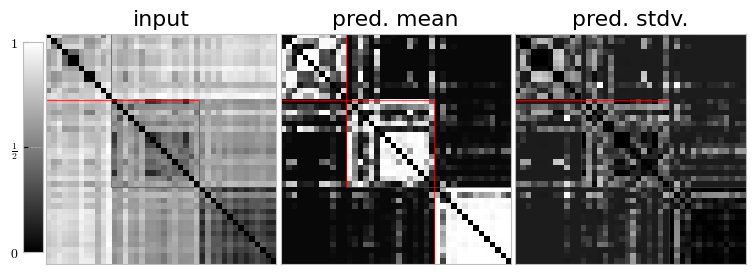

In [29]:
## Added color bar on the right

import matplotlib.pyplot as plt
import numpy as np
import jax
fontsize = 15.85
def final_figure(label, input, edge_logits, n, label_block_sizes):
    print(f"Label {label.shape}, Input {input.shape}, Edge logits {edge_logits.shape}")
    edge_probs = jax.nn.sigmoid(edge_logits)
    
    mean_edge_probs = edge_probs.mean(axis=0, keepdims=False)
    std_edge_probs = edge_probs.std(axis=0, keepdims=False)
    mean_edge_probs_adj = vec2adj(mean_edge_probs, n=n).squeeze()
    std_edge_probs_adj = vec2adj(std_edge_probs, n=n).squeeze()

    # plot label, mean, and std
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))

    im0 = axs[0].imshow(input[0], cmap='gray')
    axs[0].set_title('input', fontsize=fontsize)

    im1 = axs[1].imshow(mean_edge_probs_adj, cmap='gray')
    axs[1].set_title('pred. mean', fontsize=fontsize)

    im2 = axs[2].imshow(std_edge_probs_adj * 10, #std_edge_probs.max(), 
                        cmap='gray')
    axs[2].set_title('pred. stdv.', fontsize=fontsize)

    # Block sizes for the sector_graph_label_test_mat, used for drawing the block diagonals
    block_indices = np.cumsum([0] + label_block_sizes)
    for ax, data_adj in zip(axs.flat, [input[0], mean_edge_probs_adj, std_edge_probs_adj]):
        for start, end in zip(block_indices[:-1], block_indices[1:]):
            rect = plt.Rectangle((start-0.5, start-0.5), end-start, end-start, 
                                 fill=False, color='red', linestyle='-', linewidth=0.5)
            ax.add_patch(rect)

    for ax in axs.flat:
        ax.set(xticks=[], yticks=[])

    plt.subplots_adjust(wspace=0.02, hspace=0.0)  # Reduced horizontal spacing

    # Adjust the main figure to make space for the colorbar
    fig.subplots_adjust(left=0.15, right=0.85)

    # Add colorbar to the left of the plots
    cbar_ax = fig.add_axes([0.1275, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im1, cax=cbar_ax)

    # Set ticks and labels
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels(['$0$', r'$\frac{1}{2}$', r'$1$'])
    cbar.ax.yaxis.set_ticks_position('left')
    #plt.subplots_adjust(wspace=.01, hspace=0, bottom=0.0, top=1, left=0.0, right=1.0)   
    plt.savefig(FIGURES_PATH + 'SP500_equities_uncertainty', dpi=1000, bbox_inches='tight', pad_inches=0.00)

# Call your function with appropriate arguments here
final_figure(sector_graph_label_test_mat, log_return_observations_test_mat, 
             jnp.expand_dims(test_edge_logits, 1), # only one sample
             n_test, [12, 16, 14])
